In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

np.random.seed(2021)

import warnings
warnings.filterwarnings(action='ignore')

## matplotlib 사용시 한국어 나오게 하는 코드
import matplotlib.font_manager as fm
!apt -qq -y install fonts-nanum
fontpath = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf'
font = fm.FontProperties(fname=fontpath, size=9)
fm._rebuild()

# 그래프에 retina display 적용
%config InlineBackend.figure_format = 'retina'

# Colab 의 한글 폰트 설정
plt.rc('font', family='NanumBarunGothic')

fonts-nanum is already the newest version (20170925-1).
0 upgraded, 0 newly installed, 0 to remove and 37 not upgraded.


In [3]:
df1  = pd.read_csv("/content/drive/MyDrive/프로젝트/서울빅데이터대회/1.데이터/동별_지수.csv")
df1.head()

,시군구,행정동,행정동코드,최종지수,65세이상장애인수,수급권자수,65세이상인구수,독거노인,복지계열종사자수
0,종로구,사직동,11110530,12.171837,0.081481,0.059448,0.205964,0.240703,0.00000
1,종로구,삼청동,11110540,8.794331,0.033471,0.012739,0.069299,0.097671,0.00000
2,종로구,부암동,11110550,11.909092,0.093278,0.050955,0.209224,0.199428,0.00000
3,종로구,평창동,11110560,15.632887,0.162140,0.082803,0.402390,0.307724,0.00000
4,종로구,무악동,11110570,10.954920,0.095473,0.087049,0.161898,0.136085,0.04878


In [4]:
df1.isna().sum()

시군구          0
행정동          0
행정동코드        0
최종지수         0
65세이상장애인수    0
수급권자수        0
65세이상인구수     0
독거노인         0
복지계열종사자수     0
dtype: int64

In [5]:
df2 = pd.read_excel("/content/drive/MyDrive/프로젝트/서울빅데이터대회/1.데이터/seoul_gu_sco_v2.xlsx")
df2 = df2[['result','지역']]
df2.head()

,result,지역
0,9.192956,종로구
1,7.299337,중구
2,11.571015,용산구
3,9.307847,성동구
4,12.389070,광진구


In [6]:
final = pd.merge(df1, df2, left_on = '시군구', right_on = '지역', how = 'inner')
final = final[['시군구','행정동','최종지수','result']]
final.rename(columns={'최종지수' : '동별지수','result' : '구별지수'},inplace=True)
final.head()

,시군구,행정동,동별지수,구별지수
0,종로구,사직동,12.171837,9.192956
1,종로구,삼청동,8.794331,9.192956
2,종로구,부암동,11.909092,9.192956
3,종로구,평창동,15.632887,9.192956
4,종로구,무악동,10.954920,9.192956


In [7]:
from sklearn.preprocessing import StandardScaler
final[['동별지수','구별지수']] = StandardScaler().fit_transform(final[['동별지수','구별지수']])
final.head()

,시군구,행정동,동별지수,구별지수
0,종로구,사직동,-1.106428,-1.386583
1,종로구,삼청동,-1.735670,-1.386583
2,종로구,부암동,-1.155379,-1.386583
3,종로구,평창동,-0.461622,-1.386583
4,종로구,무악동,-1.333144,-1.386583


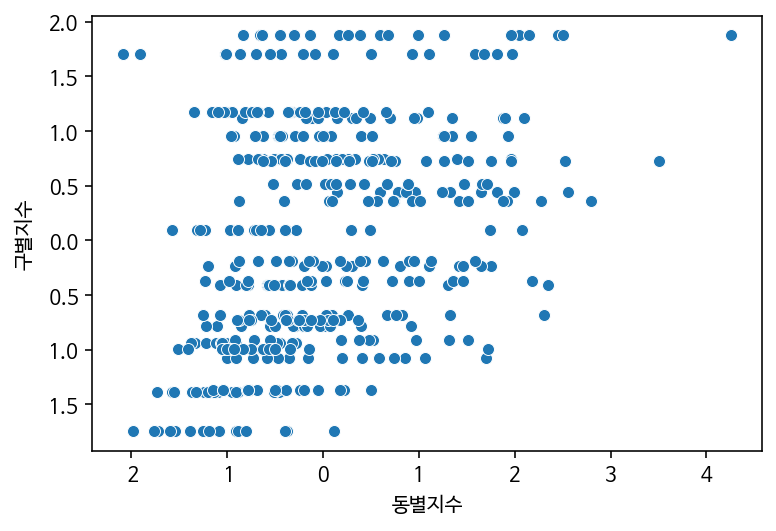

In [8]:
sns.scatterplot(final['동별지수'],final['구별지수'])

### GMM  
확률을 기반으로 한 군집화  
데이터가 N개의 정규분포집단 중 하나로부터 랜덤하게 나타났다는 것을 가정으로 함.  
타원형으로 분포된 데이터일수록 효과가 좋은데 현재 우리의 데이터는 그런 형태가 아니므로 좋은 클러스터링은 되지 않은 듯.  
GMM의 경우 평가는 BIC,AIC로 진행하므로 그래프를 그려 최저 IC들이 나오는 값으로 k를 결정한다. 

In [9]:
from sklearn.mixture import GaussianMixture

gmm = GaussianMixture(n_components=3,n_init=10,random_state = 2021)
gmm.fit(final[['동별지수','구별지수']])
y_pred = gmm.predict(final[['동별지수','구별지수']])

In [10]:
final['cluster'] = y_pred

Text(0.5, 1.0, 'GMM 클러스터링 결과')

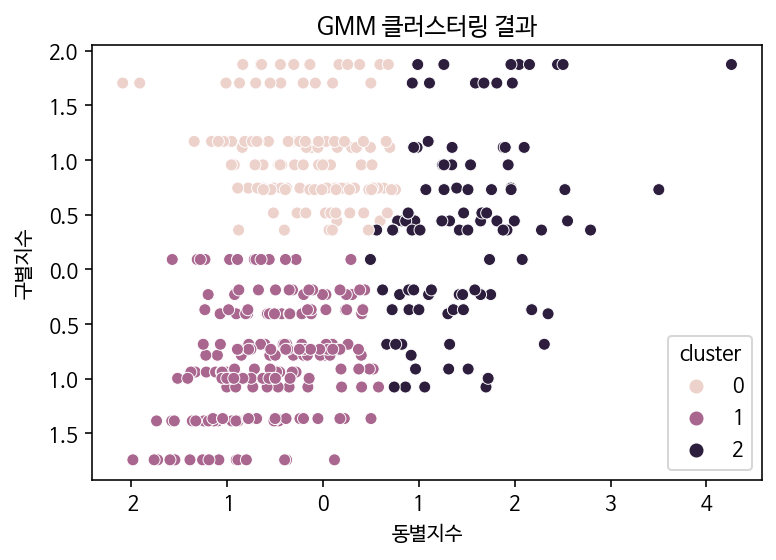

In [11]:
sns.scatterplot(x = final['동별지수'],y = final['구별지수'],hue=final['cluster'])
plt.title('GMM 클러스터링 결과')

In [12]:
gmm.bic(final[['동별지수','구별지수']])

2286.9463818321606

In [13]:
gmm.aic(final[['동별지수','구별지수']])

2218.0608659604454

### GMM의 n_cluster찾기

In [14]:
X = final[['동별지수','구별지수']]

In [15]:
bic = []
aic = []
k = []
for i in range(1,20):
  model_name = f'gmm_{i}'
  model_name = GaussianMixture(n_components=i,random_state = 2021).fit(X)
  k.append(i)
  bic.append(model_name.bic(X))
  aic.append(model_name.aic(X))

In [16]:
result = pd.DataFrame({
    'k' : k,
    'BIC' : bic,
    'AIC' : aic
})
result

,k,BIC,AIC
0,1,2387.155861,2366.895415
1,2,2282.348707,2237.775726
2,3,2287.007533,2218.122017
3,4,2310.906788,2217.708737
4,5,2321.292155,2203.781569
5,6,2274.781714,2132.958593
6,7,2293.744325,2127.608669
7,8,2386.581002,2196.132811
8,9,2421.804443,2207.043717
9,10,2374.660101,2135.586840


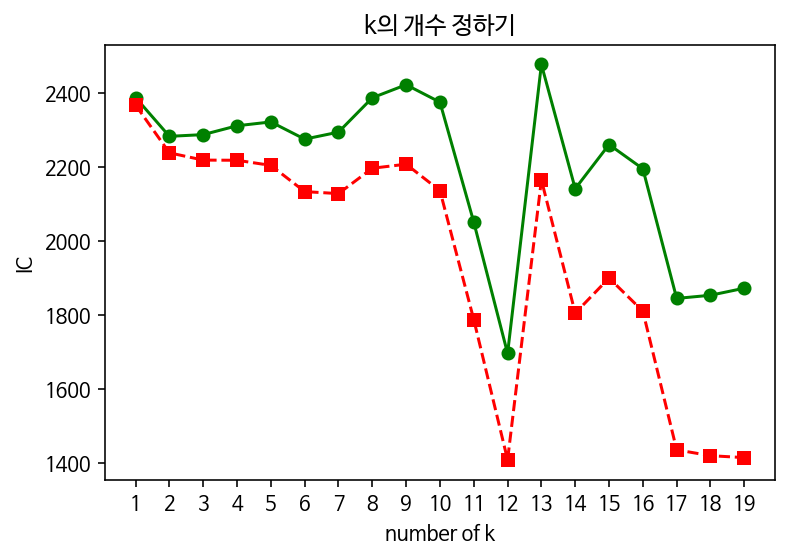

In [17]:
plt.plot(result.k, result.BIC,'go-')
plt.plot(result.k,result.AIC, 'rs--')
plt.xticks([x for x in range(1,20)],result.k)
plt.xlabel('number of k')
plt.ylabel('IC')
plt.title('k의 개수 정하기')
plt.show()

k가....12..?

In [41]:
gmm = GaussianMixture(n_components=12,n_init=10,random_state = 2021)
gmm.fit(X)
final['cluster'] = gmm.predict(X)

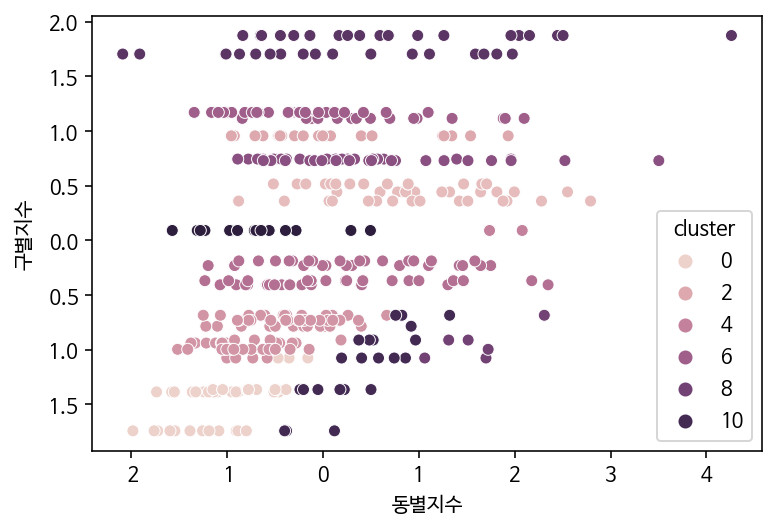

In [42]:
sns.scatterplot(x = final['동별지수'],y = final['구별지수'],hue=final['cluster'])

In [43]:
pd.pivot_table(data = final, index='cluster',aggfunc='mean').sort_values(by='구별지수',ascending=False)

,구별지수,동별지수
cluster,,
9,1.790635,0.473465
6,1.149452,-0.048859
2,0.955245,0.132077
7,0.735883,0.361578
1,0.435089,0.883641
4,0.089939,1.907798
11,0.089939,-0.712499
5,-0.303039,0.216509
3,-0.847145,-0.536844


In [44]:
final[final.cluster == 9]['행정동']

157      월계1동
158      월계2동
159      월계3동
160      공릉2동
161      하계1동
162      하계2동
163      중계본동
164      중계1동
165      중계4동
166      상계1동
167      상계2동
168      상계5동
169      상계8동
170      상계9동
171     상계10동
172    상계3.4동
173    상계6.7동
174    중계2.3동
175      공릉1동
407       강일동
408       상일동
409      명일1동
410      명일2동
411      고덕1동
412      고덕2동
413      암사2동
414      암사3동
415      천호1동
416      천호3동
417      성내1동
418      성내2동
419      성내3동
420      둔촌1동
421      둔촌2동
422      암사1동
423      천호2동
424        길동
Name: 행정동, dtype: object

In [45]:
final[final.cluster == 6]['행정동']

94       면목2동
95       면목4동
96       면목5동
97       면목7동
98       상봉1동
99       상봉2동
100      중화1동
101      중화2동
102       묵1동
103       묵2동
104      망우3동
105      신내1동
106      신내2동
107      면목본동
108    면목3.8동
109      망우본동
380      풍납1동
381      풍납2동
382      거여1동
383      거여2동
384      마천1동
385      마천2동
386      방이1동
387      방이2동
388       오륜동
389       오금동
390      송파1동
391      송파2동
392       석촌동
393       삼전동
394      가락본동
395      가락1동
396      가락2동
397      문정1동
398      문정2동
399      잠실본동
400      잠실4동
401      잠실6동
402      잠실7동
403      잠실2동
404      잠실3동
405       장지동
406       위례동
Name: 행정동, dtype: object

### BGMM
GMM의 n_components를 결정하기위한 다른 방법으로는 BGMM을 사용하기도 함.  
n_components를 확률상 제일 큰 수로 해놓으면 필요 없는 클러스터는 0으로 나타남.

In [34]:
from sklearn.mixture import BayesianGaussianMixture

bgm = BayesianGaussianMixture(n_components=20, n_init=10, random_state=42)
bgm.fit(final[['동별지수','구별지수']])

BayesianGaussianMixture(covariance_prior=None, covariance_type='full',
                        degrees_of_freedom_prior=None, init_params='kmeans',
                        max_iter=100, mean_precision_prior=None,
                        mean_prior=None, n_components=20, n_init=10,
                        random_state=42, reg_covar=1e-06, tol=0.001, verbose=0,
                        verbose_interval=10, warm_start=False,
                        weight_concentration_prior=None,
                        weight_concentration_prior_type='dirichlet_process')

In [35]:
np.round(bgm.weights_,2)

array([0.38, 0.32, 0.3 , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ,
       0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  , 0.  ])

현재 클러스터를 3으로 하는게 낫다는 결과

In [36]:
y_bpred = bgm.predict(final[['동별지수','구별지수']])
final['cluster'] = y_bpred

Text(0.5, 1.0, 'BGMM 클러스터링 결과')

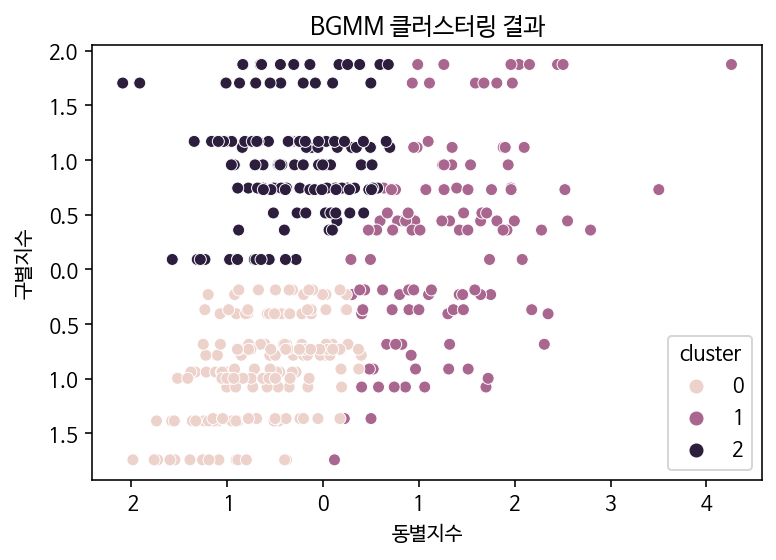

In [37]:
sns.scatterplot(x = final['동별지수'],y = final['구별지수'],hue=final['cluster'])
plt.title('BGMM 클러스터링 결과')

### 구별 순서대로 되어있어서 결과가 이렇게 나오는건 아닐까...

In [38]:
sorted_final = final.sort_values(by='행정동').reset_index()
del sorted_final['cluster']
sorted_final.head()

,index,시군구,행정동,동별지수,구별지수
0,395,송파구,가락1동,-0.739771,1.169851
1,396,송파구,가락2동,-0.243108,1.169851
2,394,송파구,가락본동,-0.362582,1.169851
3,271,구로구,가리봉동,-0.783339,-0.369478
4,276,금천구,가산동,-0.551274,-0.911960


([<matplotlib.axis.XTick at 0x7f2681fbf710>,
 [Text(0, 0, '1'),
  Text(0, 0, '2'),
  Text(0, 0, '3'),
  Text(0, 0, '4'),
  Text(0, 0, '5'),
  Text(0, 0, '6'),
  Text(0, 0, '7'),
  Text(0, 0, '8'),
  Text(0, 0, '9'),
  Text(0, 0, '10'),
  Text(0, 0, '11'),
  Text(0, 0, '12'),
  Text(0, 0, '13'),
  Text(0, 0, '14'),
  Text(0, 0, '15'),
  Text(0, 0, '16'),
  Text(0, 0, '17'),
  Text(0, 0, '18'),
  Text(0, 0, '19')])

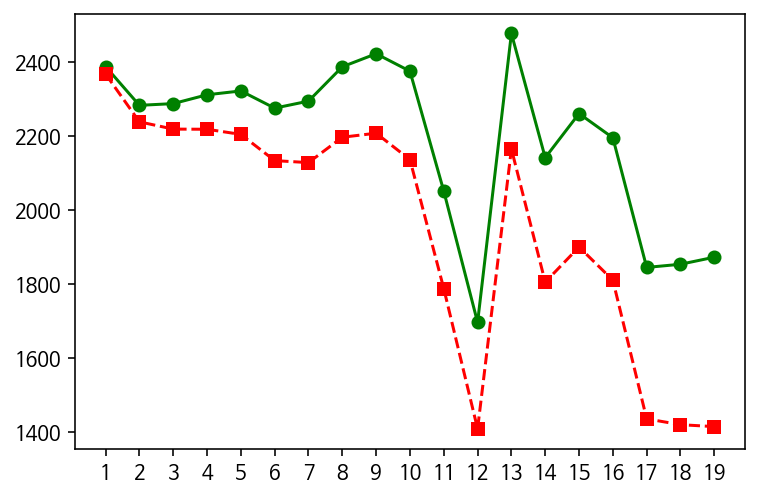

In [39]:
X2 = sorted_final[['동별지수','구별지수']]
bic = []
aic = []
k = []
for i in range(1,20):
  model_name = f'gmm_{i}'
  model_name = GaussianMixture(n_components=i,random_state = 2021).fit(X2)
  k.append(i)
  bic.append(model_name.bic(X2))
  aic.append(model_name.aic(X2))

plt.plot(result.k, result.BIC,'go-')
plt.plot(result.k,result.AIC, 'rs--')
plt.xticks([x for x in range(1,20)],result.k)

동일한 결과,,,